In [ ]:

import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import (
    SelectKBest,
    mutual_info_regression,
    SelectFromModel
)
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge


Load data

In [ ]:

train = pd.read_csv("processed_data/train_unscaled.csv")
val   = pd.read_csv("processed_data/val_unscaled.csv")
test  = pd.read_csv("processed_data/test_unscaled.csv")

print("Train shape:", train.shape)
print("Val shape  :", val.shape)
print("Test shape :", test.shape)

target_col = "price"
feature_cols = [c for c in train.columns if c != target_col]

X_train = train[feature_cols]
y_train = train[target_col]

X_val   = val[feature_cols]
y_val   = val[target_col]

X_test  = test[feature_cols]
y_test  = test[target_col]

print("\nExample features:")
display(X_train.head())
print("\nTarget stats (train):")
print(y_train.describe())


Train shape: (12003, 97)
Val shape  : (4001, 97)
Test shape : (4001, 97)

Example features:


,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,...,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_60,neighbourhood_target_encoded,neighbourhood_cleansed_target_encoded,property_type_target_encoded,host_name_target_encoded,host_location_target_encoded,host_neighbourhood_target_encoded
0,1.0,0,1.0,1.0,1,0,52.373421,4.879066,0,4,...,1,0,0,0,178.745052,182.076625,190.397260,148.500000,153.630625,176.284536
1,NaN,0,1.0,1.0,1,0,52.374936,4.861050,0,2,...,1,0,1,0,116.164825,141.753702,141.951824,123.370370,144.034926,138.655319
2,NaN,0,1.0,1.0,1,0,52.363471,4.935530,1,4,...,1,0,0,0,119.129348,125.830031,141.951824,162.033333,144.034926,116.631054
3,NaN,0,1.0,1.0,1,1,52.352976,4.926950,1,4,...,1,0,1,0,140.488095,136.846014,141.951824,117.500000,154.666667,136.103896
4,NaN,0,1.0,1.0,1,0,52.362441,4.934438,1,2,...,1,0,0,0,119.129348,125.830031,141.951824,145.365385,153.630625,116.631054



Target stats (train):
count    12003.000000
mean       147.756478
std         81.002091
min         40.000000
25%         97.000000
50%        125.000000
75%        175.000000
max        500.000000
Name: price, dtype: float64


In [ ]:
df = pd.read_csv("processed_data/train_unscaled.csv")


In [ ]:
print(df.columns)

Index(['host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'is_location_exact',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'host_tenure_days', 'host_tenure_years',
       'days_since_f

In [ ]:
CITY_LAT = 52.3676
CITY_LON = 4.9041

df["dist_to_center"] = np.sqrt(
    (df["latitude"] - CITY_LAT)**2 +
    (df["longitude"] - CITY_LON)**2
)

# ---- Amsterdam Central Station ----
CENTRAL_LAT = 52.3791
CENTRAL_LON = 4.8994

df["dist_to_central_station"] = np.sqrt(
    (df["latitude"] - CENTRAL_LAT)**2 +
    (df["longitude"] - CENTRAL_LON)**2
)

# ---- Rijksmuseum (52.3600° N, 4.8852° E) ----
RIJK_LAT = 52.3600
RIJK_LON = 4.8852

df["dist_to_rijksmuseum"] = np.sqrt(
    (df["latitude"] - RIJK_LAT)**2 +
    (df["longitude"] - RIJK_LON)**2
)

# ---- Vondelpark (52.3580° N, 4.8686° E) ----
VONDEL_LAT = 52.3580
VONDEL_LON = 4.8686

df["dist_to_vondelpark"] = np.sqrt(
    (df["latitude"] - VONDEL_LAT)**2 +
    (df["longitude"] - VONDEL_LON)**2
)

# ---- Schiphol Airport (52.3128° N, 4.7402° E) ----
SCHIPHOL_LAT = 52.3128
SCHIPHOL_LON = 4.7402

df["dist_to_schiphol"] = np.sqrt(
    (df["latitude"] - SCHIPHOL_LAT)**2 +
    (df["longitude"] - SCHIPHOL_LON)**2
)

print("Added location-based features:",
      ["dist_to_center",
       "dist_to_central_station",
       "dist_to_rijksmuseum",
       "dist_to_vondelpark",
       "dist_to_schiphol"])

Added location-based features: ['dist_to_center', 'dist_to_central_station', 'dist_to_rijksmuseum', 'dist_to_vondelpark', 'dist_to_schiphol']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")



**List of new engineered features**

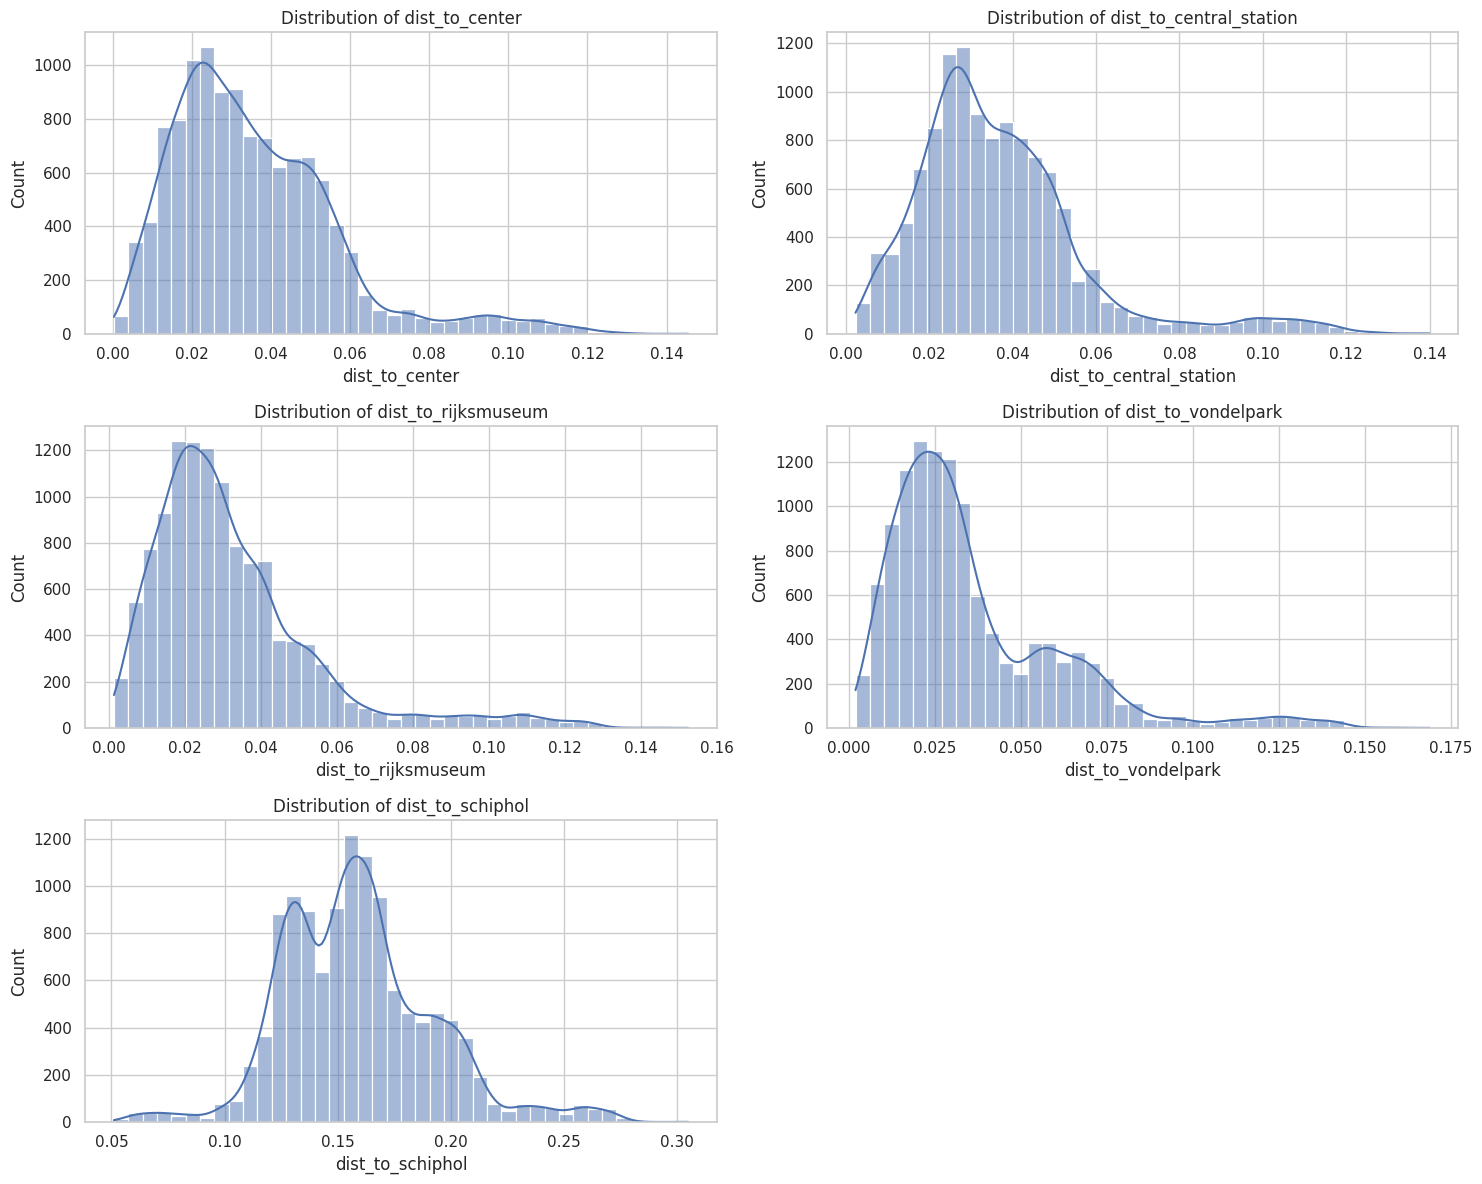

In [ ]:

loc_features = [
    "dist_to_center",
    "dist_to_central_station",
    "dist_to_rijksmuseum",
    "dist_to_vondelpark",
    "dist_to_schiphol"
]

plt.figure(figsize=(15, 12))

for i, col in enumerate(loc_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


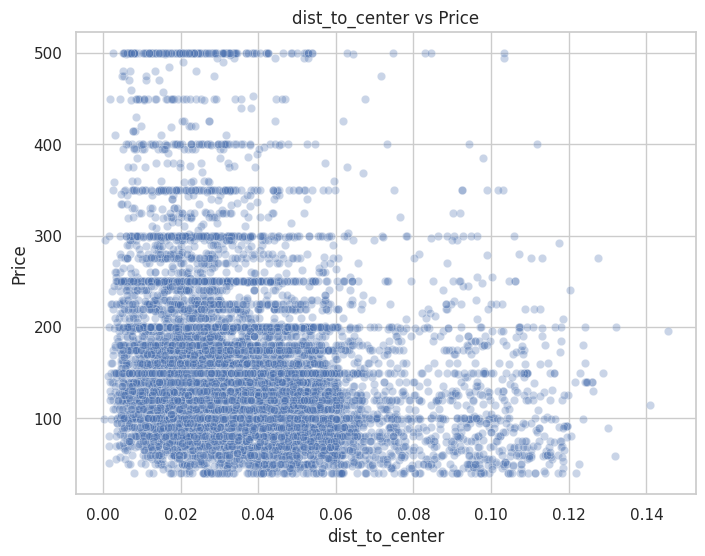

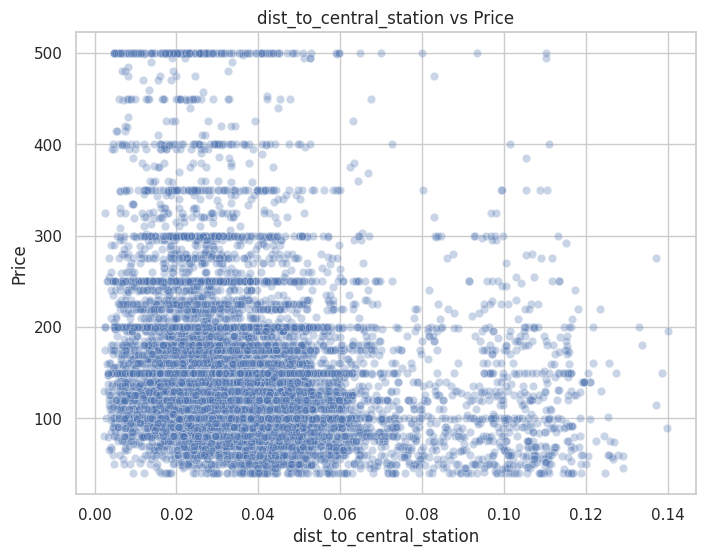

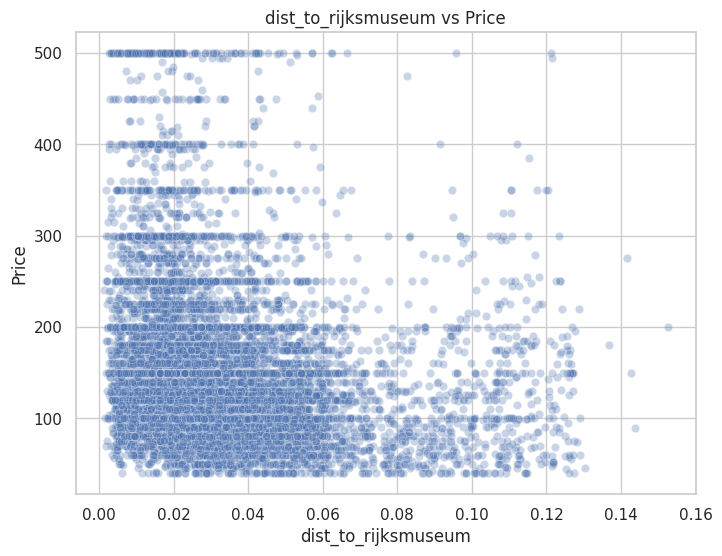

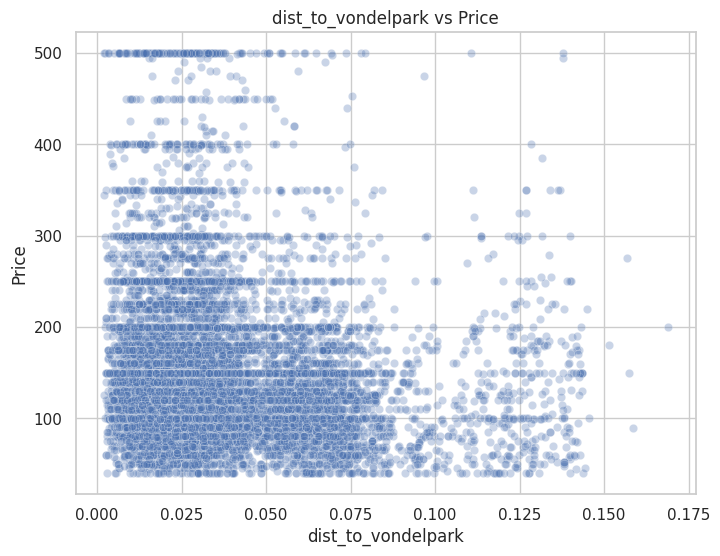

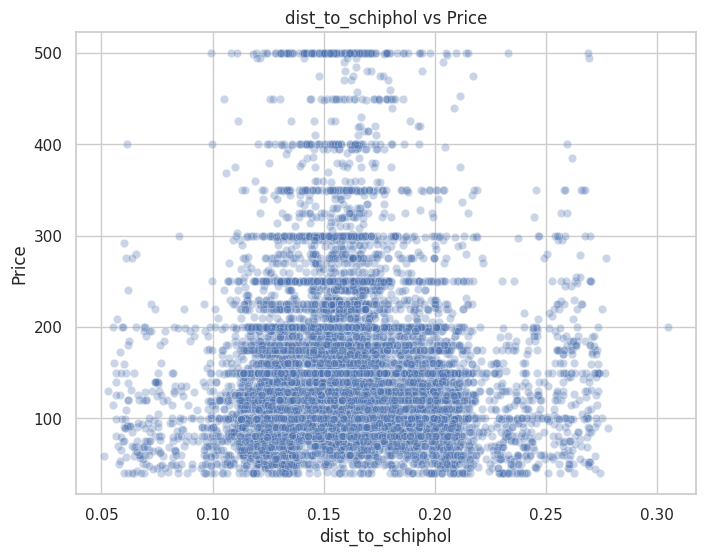

In [ ]:
for col in loc_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y="price", alpha=0.3)
    plt.title(f"{col} vs Price")
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.show()


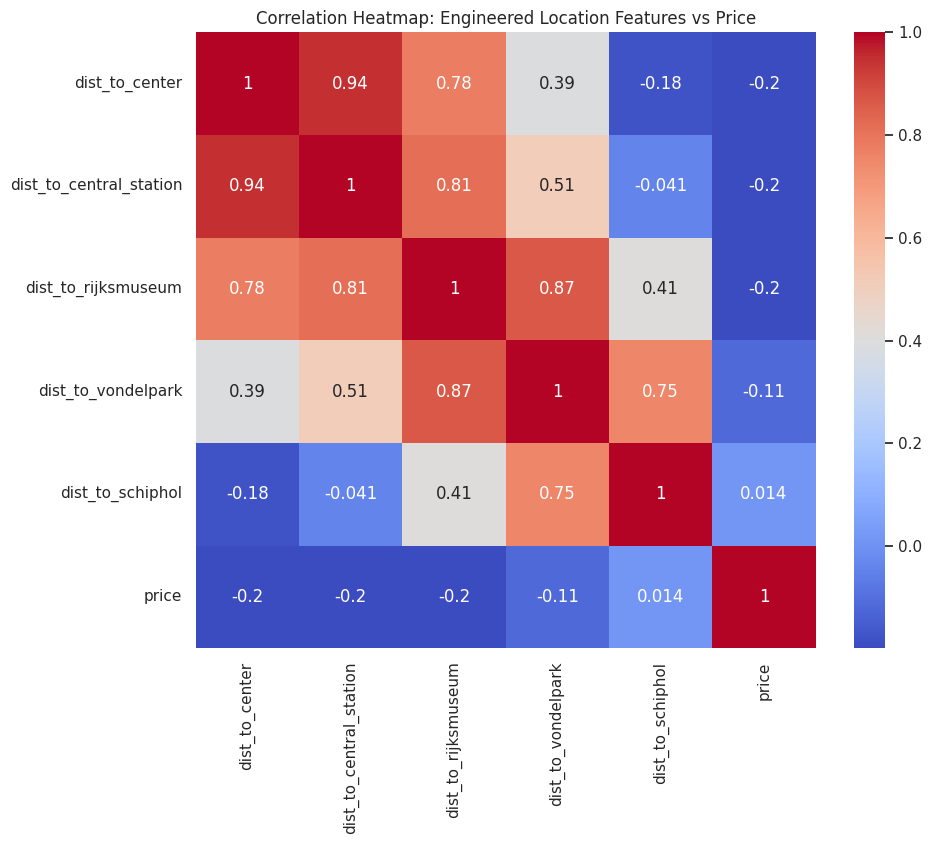

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[loc_features + ["price"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap: Engineered Location Features vs Price")
plt.show()


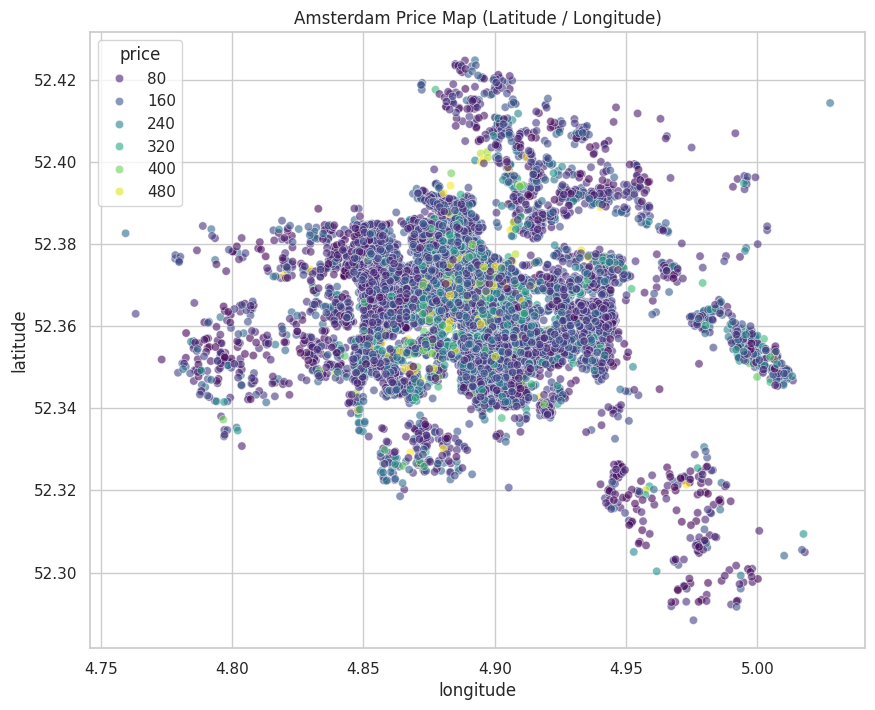

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x="longitude",
    y="latitude",
    hue="price",
    palette="viridis",
    alpha=0.6
)
plt.title("Amsterdam Price Map (Latitude / Longitude)")
plt.show()


In [ ]:
ridge_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectFromModel(Lasso(alpha=0.001))),
    ("pca", PCA(n_components=20)),
    ("model", Ridge())
])


In [ ]:
gbr_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("select", SelectFromModel(Lasso(alpha=0.001))),
    ("model", GradientBoostingRegressor(random_state=42))
])


In [ ]:
svr_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectFromModel(Lasso(alpha=0.001))),
    ("pca", PCA(n_components=20)),
    ("model", SVR())
])


# Bayesian Ridge Pipeline (replacing ExtraTrees)
bayesian_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", BayesianRidge())
])

# Stacking Pipeline with Ridge, GBR, and ExtraTrees as base estimators
stacking_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", StackingRegressor(
        estimators=[
            ('ridge', Ridge(alpha=1.0)),
            ('gbr', GradientBoostingRegressor(random_state=42)),
            ('bayes', BayesianRidge())
        ],
        final_estimator=Ridge(),
        cv=5
    ))
])


In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# ===== Common preprocessing =====
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


# ========= 1) Ridge (Linear Model) ==========
ridge_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),

    # Filter method
    ("select", SelectKBest(mutual_info_regression, k=40)),

    # Dimensionality reduction
    ("pca", PCA(n_components=20, random_state=42)),

    ("model", Ridge())
])


# ========= 2) Gradient Boosting (Ensemble) ==========
gbr_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),

    # Embedded feature selection (no leakage)
    ("select", SelectFromModel(GradientBoostingRegressor(random_state=42),
                               threshold="median")),

    ("model", GradientBoostingRegressor(random_state=42))
])


# ========= 3) SVR (Support-Based) ==========
svr_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),



    # Filter method
    ("select", SelectKBest(mutual_info_regression, k=40)),

    # PCA helps SVM a LOT
    ("pca", PCA(n_components=20, random_state=42)),

    ("model", SVR())
])


# Bayesian Ridge Pipeline
bayesian_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", BayesianRidge())
])

# Stacking Pipeline with Ridge, GBR, and Bayesian Ridge as base estimators
stacking_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", StackingRegressor(
        estimators=[
            ('ridge', Ridge(alpha=1.0)),
            ('gbr', GradientBoostingRegressor(random_state=42)),
            ('bayes', BayesianRidge())
        ],
        final_estimator=Ridge(),
        cv=5
    ))
])


#Dimensionality Reduction


***Common Preprocessing***

1.   Ridge + PCA Pipeline
2.  Gradient Boosting (NO PCA needed)
3. SVR + PCA Pipeline



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# ================================
# Common Preprocessing
# ================================
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# =======================
# 1️⃣ Ridge + PCA Pipeline
# =======================
ridge_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),

    # Feature selection
    ("select", SelectKBest(mutual_info_regression, k=40)),

    # Dimensionality reduction
    ("pca", PCA(n_components=20, random_state=42)),

    ("model", Ridge())
])

# ======================================
# 2️⃣ Gradient Boosting (NO PCA needed)
# ======================================
gbr_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),

    # Embedded feature selection (tree-based)
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median"
    )),

    # No PCA here
    ("model", GradientBoostingRegressor(random_state=42))
])

# ===============================
# 3️⃣ SVR + PCA Pipeline
# ===============================
svr_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),

    # Feature selection
    ("select", SelectKBest(mutual_info_regression, k=40)),

    # Dimensionality reduction for SVM
    ("pca", PCA(n_components=20, random_state=42)),

    ("model", SVR())
])

print("Pipelines with dimensionality reduction are ready.")


# Bayesian Ridge Pipeline
extratrees_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", BayesianRidge())
])

# Stacking Pipeline with Ridge, GBR, and ExtraTrees as base estimators
stacking_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", StackingRegressor(
        estimators=[
            ('ridge', Ridge(alpha=1.0)),
            ('gbr', GradientBoostingRegressor(random_state=42)),
            ('bayes', BayesianRidge())
        ],
        final_estimator=Ridge(),
        cv=5
    ))
])


Pipelines with dimensionality reduction are ready.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Train each model pipeline

In [ ]:
# Train Ridge Regression
print("Training Ridge Regression...")
ridge_pipeline.fit(X_train, y_train)

# Train Gradient Boosting Regressor
print("Training Gradient Boosting Regressor...")
gbr_pipeline.fit(X_train, y_train)

# Train Support Vector Regressor
print("Training Support Vector Regressor...")
svr_pipeline.fit(X_train, y_train)

# Train Bayesian Ridge Regressor
print("Training Bayesian Ridge Regressor...")
bayesian_pipeline.fit(X_train, y_train)

# Train Stacking Regressor
print("Training Stacking Regressor...")
stacking_pipeline.fit(X_train, y_train)

print("All models trained successfully.")


Training Ridge Regression...
Training Gradient Boosting Regressor...
Training Support Vector Regressor...
Training Bayesian Ridge Regressor...
Training Stacking Regressor...
All models trained successfully.


**Evaluate on validation set**

In [ ]:

def evaluate(model, X, y, name=""):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"\n===== {name} on Validation Set =====")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"R²  : {r2:.3f}")

    return {"rmse": rmse, "mae": mae, "r2": r2}


results_val = {}
results_val["Ridge"] = evaluate(ridge_pipeline, X_val, y_val, "Ridge")
results_val["GradientBoosting"] = evaluate(gbr_pipeline, X_val, y_val, "Gradient Boosting")
results_val["SVR"] = evaluate(svr_pipeline, X_val, y_val, "SVR")

results_val["BayesianRidge"] = evaluate(bayesian_pipeline, X_val, y_val, "Bayesian Ridge")
results_val["Stacking"] = evaluate(stacking_pipeline, X_val, y_val, "Stacking")



===== Ridge on Validation Set =====
RMSE: 55.457
MAE : 37.477
R²  : 0.574

===== Gradient Boosting on Validation Set =====
RMSE: 48.307
MAE : 32.193
R²  : 0.677

===== SVR on Validation Set =====
RMSE: 66.413
MAE : 40.422
R²  : 0.389

===== Bayesian Ridge on Validation Set =====
RMSE: 52.102
MAE : 35.435
R²  : 0.624

===== Stacking on Validation Set =====
RMSE: 48.142
MAE : 32.155
R²  : 0.679


 Choose the best model

In [ ]:
best_model_name = min(results_val, key=lambda k: results_val[k]["rmse"])
best_model = {
    "Ridge": ridge_pipeline,
    "GradientBoosting": gbr_pipeline,
    "SVR": svr_pipeline,
    "BayesianRidge": bayesian_pipeline,
    "Stacking": stacking_pipeline
}[best_model_name]

print(f"\n🎉 Best model on validation: {best_model_name}")


🎉 Best model on validation: Stacking


 Best model on validation: Stacking


**Final evaluation on test sett**

In [ ]:

# 4.
# ============================
y_pred_test = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\n===== FINAL TEST RESULTS ({best_model_name}) =====")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAE : {mae_test:.3f}")
print(f"R²  : {r2_test:.3f}")


===== FINAL TEST RESULTS (Stacking) =====
RMSE: 45.200
MAE : 30.428
R²  : 0.668


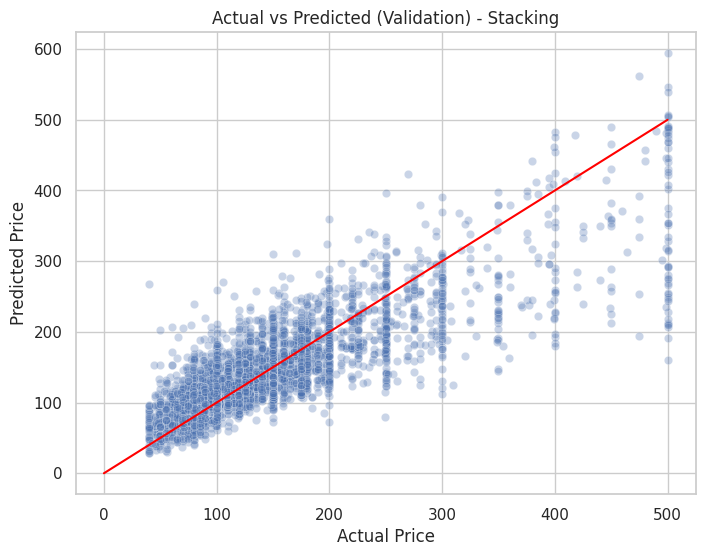

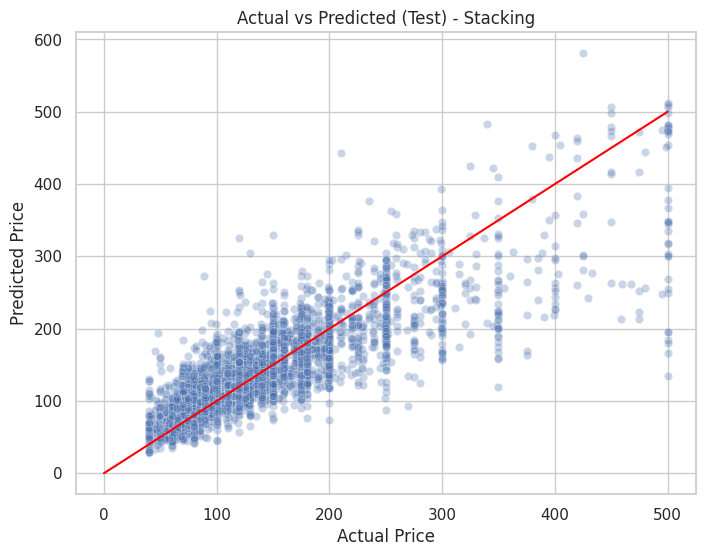

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Validation
y_pred_val = best_model.predict(X_val)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.3)
plt.plot([0, max(y_val)], [0, max(y_val)], color="red")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted (Validation) - {best_model_name}")
plt.show()

# Test
y_pred_test = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted (Test) - {best_model_name}")
plt.show()


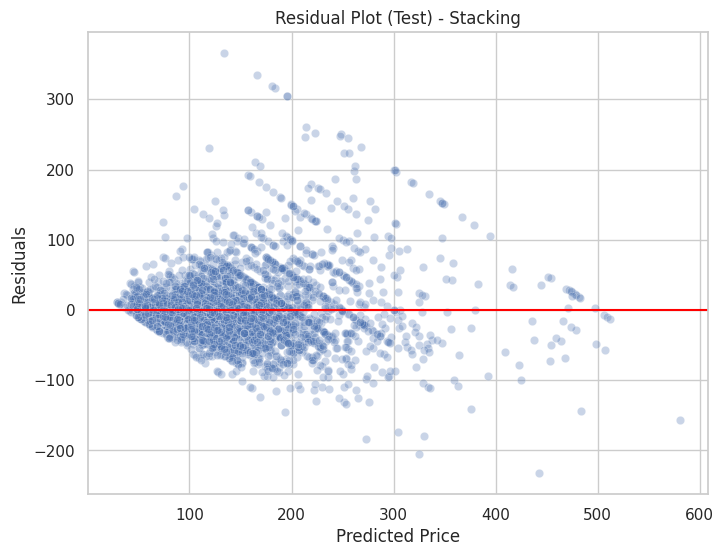

In [ ]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.3)
plt.axhline(0, color="red")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title(f"Residual Plot (Test) - {best_model_name}")
plt.show()


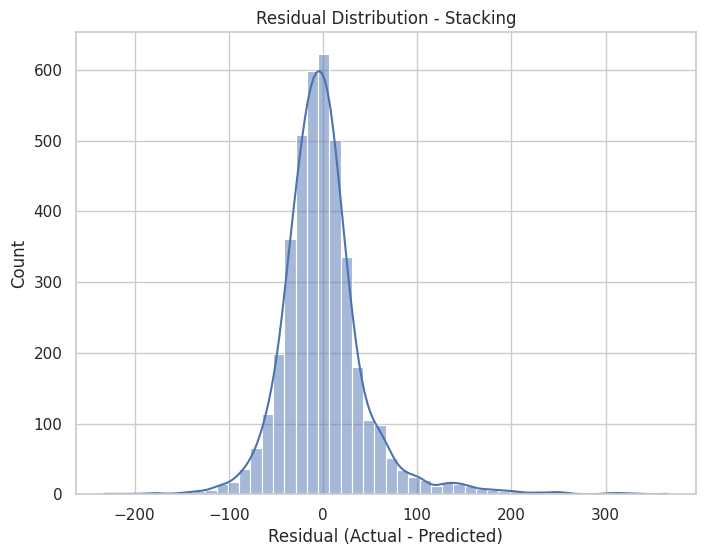

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title(f"Residual Distribution - {best_model_name}")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()


In [ ]:

summary_df = pd.DataFrame(results_val).T
summary_df


,rmse,mae,r2
Ridge,55.457038,37.476699,0.574063
GradientBoosting,48.306700,32.192597,0.676818
SVR,66.413335,40.422271,0.389138
BayesianRidge,52.101964,35.435101,0.624041
Stacking,48.141503,32.154562,0.679025


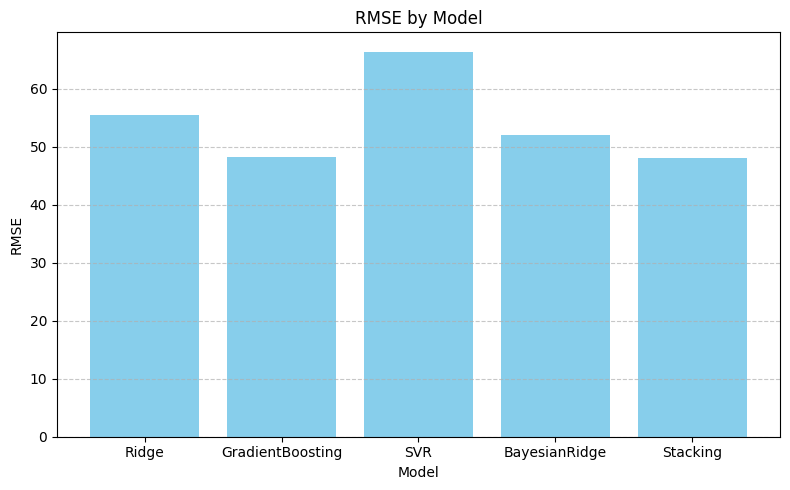

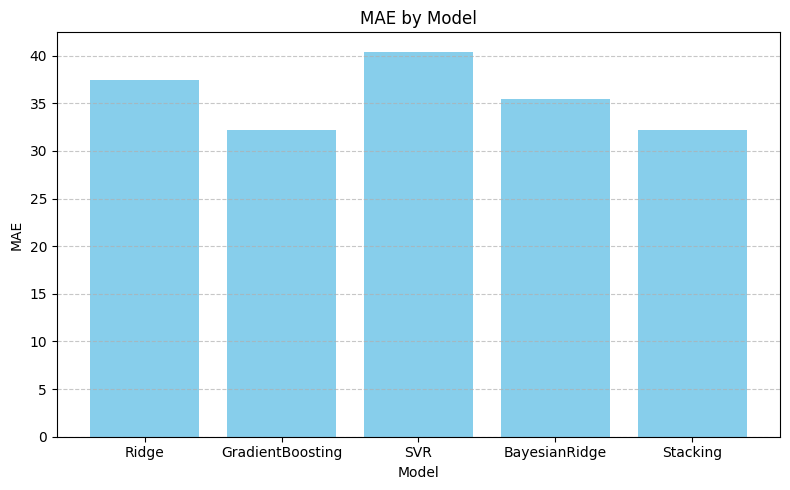

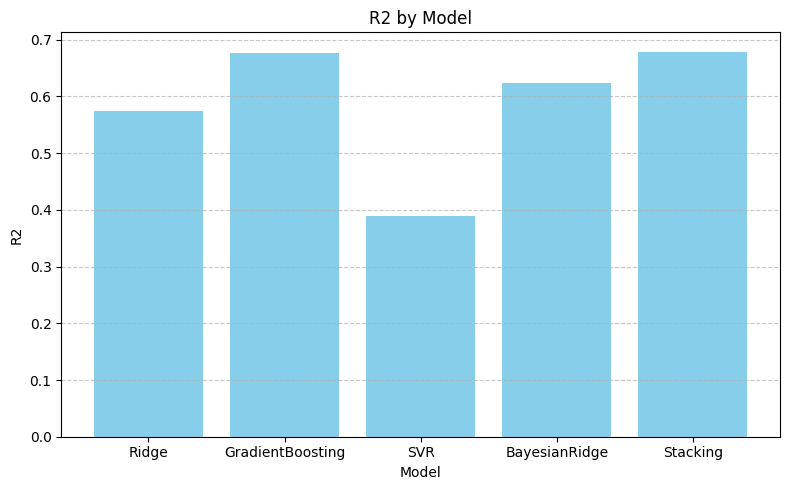

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Model performance data
data = {
    'Model': ['Ridge', 'GradientBoosting', 'SVR', 'BayesianRidge', 'Stacking'],
    'RMSE': [55.46, 48.31, 66.41, 52.10, 48.14],
    'MAE': [37.48, 32.19, 40.42, 35.44, 32.15],
    'R2': [0.5741, 0.6768, 0.3891, 0.6240, 0.6790]
}

df = pd.DataFrame(data)

# Plotting each metric as a bar chart
metrics = ['RMSE', 'MAE', 'R2']
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.bar(df['Model'], df[metric], color='skyblue')
    plt.title(f'{metric} by Model')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
plt.savefig("residual_distribution.png")
print("Plot 'residual_distribution.png' saved successfully!")

Plot 'residual_distribution.png' saved successfully!


<Figure size 640x480 with 0 Axes>